In [1]:
import pandas as pd
import numpy as np
import os
import json
import skfuzzy as fuzz
import skfuzzy.membership as mf
import matplotlib.pyplot as plt

In [2]:
def get_path(starts_with,directory=''):
  directory=os.path.join(os.getcwd(),directory)
  file=[filename for filename in os.listdir(directory) if filename.startswith(starts_with)]
  return os.path.join(directory,file[0])

In [3]:
df_abort=pd.read_csv(get_path('abortion','processed_data'))
df_ed=pd.read_csv(get_path('educa','processed_data'))
df_gdp=pd.read_csv(get_path('gdp','processed_data'))
df_health=pd.read_csv(get_path('health','processed_data'))

In [4]:
s_i=np.array(range(len(df_abort)))
s_code=df_abort['state'].values
s_name=df_ed['State'].values
s_abort=df_abort['Average Abortion Rate'].values
s_ed=df_ed['Total Estimate'].values
s_gdp=df_gdp['Average GDP'].values
s_health=[]
for state in s_name:
  spending=df_health[df_health['state']==state]['Average Spending'].values[0]
  s_health.append(spending)
s_health=np.array(s_health)

s_code=np.char.lower(s_code.astype(str))
s_name=np.char.lower(s_name.astype(str))

In [ ]:
with open(get_path('swing','processed_data')) as f:
  swing_dict=json.load(f)
s_last_party_l=[]
s_margin_l=[]
s_left_right_l=[]
indexes_l=[]
for state in swing_dict:
  indexes_l.append(np.where(s_name==state[0].lower())[0][0])
  att=state[1]
  s_last_party_l.append(att['last_party'])
  s_margin_l.append(att['average_margin'])
  if att['last_party']=='REPUBLICAN':
    s_left_right_l.append(((1-att['average_margin'])/2,(1+att['average_margin'])/2))
  else:
    s_left_right_l.append(((1+att['average_margin'])/2,(1-att['average_margin'])/2))

s_last_party=np.array(s_last_party_l)
s_margin=np.array(s_margin_l)
s_left_right=np.array(s_left_right_l)

s_last_party=s_last_party[np.argsort(np.array(indexes_l))]
s_margin=s_margin[np.argsort(np.array(indexes_l))]
s_left_right=s_left_right[np.argsort(np.array(indexes_l))]

In [ ]:
strategies=[s_abort,s_ed,s_gdp,s_health]
small_is_good_for_rep=[True,True,False,True]
data=dict()
data['strategies']=strategies
data['sigfr']=small_is_good_for_rep
data['sigfd']=[not v for v in small_is_good_for_rep]
data['s_i']=s_i
data['s_code']=s_code
data['s_name']=s_name
data['s_last_party']=s_last_party
data['s_margin']=s_margin
data['s_left_right']=s_left_right

The T-norm of a candidate preference and a policy given the membership of the candidate into voting for that party

In [9]:
def plot(dist):
  plt.figure(figsize=(2,2))
  plt.plot(dist)

In [10]:
def get_strategy_quality(state,metric,small_is_good=True):
  value=metric[state]
  if small_is_good:
    sorted=np.sort(metric)[::-1]
  else:
    sorted=np.sort(metric)
  rank=np.where(sorted==value)[0]
  print(rank)
  return rank/(len(metric)-1)

In [58]:
def calculate_payoff(dem_s,rep_s,state,data,election_outcome=True):
  #Fuzzy set of how convincing a strategy is
  x=np.arange(0,11,1)
  convinced=mf.sigmf(x,5,0.3)
  #how convincing the dem strategy is
  strat_qual=get_strategy_quality(state,data['strategies'][dem_s],data['sigfd'][dem_s])*10
  dem_s_effect=fuzz.interp_membership(x,convinced,strat_qual)
  #how convincing the rep strategy is
  strat_qual=get_strategy_quality(state,data['strategies'][rep_s],data['sigfr'][rep_s])*10
  rep_s_effect=fuzz.interp_membership(x,convinced,strat_qual)
  #People's a priori desire to vote left or right
  vote_left_right=np.arange(0,1001,1)
  vote_left=mf.trapmf(vote_left_right,[0,0,350,800])
  vote_right=mf.trapmf(vote_left_right,[200,650,1000,1000])
  print(dem_s_effect)
  print(rep_s_effect)
  #People's updated desire to vote left or right after the campaign
  vote_left=np.fmin(dem_s_effect,vote_left)
  vote_right=np.fmin(rep_s_effect,vote_right)
  #The combined outcome of the campaigns
  combined_vote_intention=np.fmax(vote_left,vote_right)
  results=fuzz.defuzz(vote_left_right,combined_vote_intention,'centroid')
  results=1-(results/1000)
  #The result of the compaigned is averaged out with previous election results
  # to reflect people's unwillingness to change
  results_left_right=((data['s_left_right'][state][0]+results)/2,(data['s_left_right'][state][1]+1-results)/2)

  if election_outcome:
    if results_left_right[0]>results_left_right[1]:
      return (1,0)
    else:
      return (0,1)
  else:
    return results_left_right
  

In [12]:
s_margin

array([0.0106582 , 0.0183337 , 0.03661338, 0.00666489, 0.01635354,
       0.01109839, 0.0127246 , 0.00876148, 0.00908188, 0.0060829 ])

In [62]:
calculate_payoff(2,3,1,data,election_result=False)

[0]
[6]
[0.18242552]
[0.62191838]


(0.43919061312581, 0.56080938687419)

dem_s qual: [7.77777778]
rep_s qual: [3.33333333]
dem_s effect: [0.6964399]
rep_s effect: [0.37808162]
election results: (0.530980678084554, 0.46901932191544604)


(0.530980678084554, 0.46901932191544604)

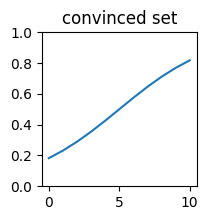

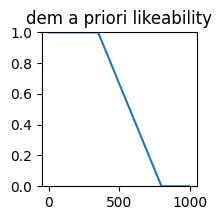

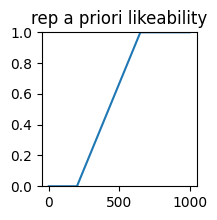

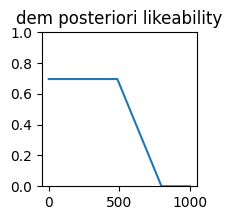

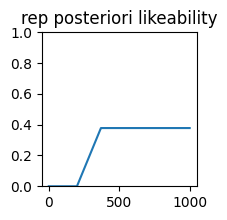

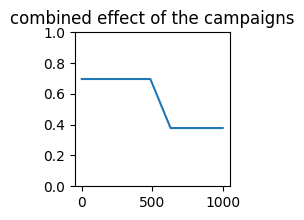

In [4]:
from fuzzy import get_data,calculate_payoff
data=get_data()
calculate_payoff(2,3,4,data,election_outcome=False,log=True,charts=True)